In [211]:
# Quake Forecast: Predict Time, Location and Magnitude of a Quake
import pandas as pd
import time
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
from calendar import Calendar
import matplotlib.pyplot as plt
import math
%matplotlib inline

## 1. TrainingSet

In [212]:
def check_file_path_exist(csvName):
    if not os.path.exists(os.path.dirname(csvName)):
        try:
            os.makedirs(os.path.dirname(csvName))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
                
def get_CSV_FileName(csvName, FolderName):
    cwd = os.getcwd()
    csvFullName = cwd + '/' + FolderName + '/' + csvName
#     print(csvFullName)
    return csvFullName

def get_TrainingDF(trainDataFrame, trainFeature):
    return trainDataFrame[trainFeature]

def get_PeriodTrainingDF(trainDataFrame):
    trainDataFrame['query_date_month_cos'] = trainDataFrame.eval('cos(query_date_month/12)')
    trainDataFrame['query_date_month_sin'] = trainDataFrame.eval('sin(query_date_month/12)')
    trainDataFrame['query_date_day_cos'] = trainDataFrame.eval('cos(query_date_day/31)')
    trainDataFrame['query_date_day_sin'] = trainDataFrame.eval('sin(query_date_day/31)')
    trainDataFrame['query_date_weekday_cos'] = trainDataFrame.eval('cos(query_date_weekday/7)')
    trainDataFrame['query_date_weekday_sin'] = trainDataFrame.eval('sin(query_date_weekday/7)')
    return trainDataFrame

def get_NormalizedTrainingDF(trainDataFrame):
    try:
        trainDataFrame['query_date_month'] = trainDataFrame['query_date_month']/12
        trainDataFrame['query_date_day'] = trainDataFrame['query_date_day']/31
        trainDataFrame['query_date_weekday'] = trainDataFrame['query_date_weekday']/7
    except:
        print("Unexpected error:", sys.exc_info())
    return trainDataFrame

In [214]:
# UserName = 'mPOS'
# UserName = 'CSIS-SIT3'
# UserName = 'user1'
UserName = 'user4'

TrainingDataFolder = 'TrainingDataSets/' + UserName + '/'
csvTrainingFile = get_CSV_FileName('TrainingFeature.csv', TrainingDataFolder)

check_file_path_exist(csvTrainingFile)

trainDF = pd.read_csv(csvTrainingFile, index_col=False )
feature = [  'query_date_year' , 'query_date_month'  ,'query_date_day', 'query_date_weekday'  ]
data = pd.get_dummies(get_TrainingDF(trainDF,feature))
data = get_PeriodTrainingDF(data)
data = get_NormalizedTrainingDF(data)

docDF = pd.read_csv(csvTrainingFile, index_col=False)['doc'].value_counts(0)
docDFHead = docDF.axes[0]

In [215]:
# data['query_date_month_cos'] = data.eval('cos(query_date_month/12)')
# data['query_date_month_sin'] = data.eval('sin(query_date_month/12)')
# data['query_date_day_cos'] = data.eval('cos(query_date_day/31)')
# data['query_date_day_sin'] = data.eval('sin(query_date_day/31)')
# data['query_date_weekday_cos'] = data.eval('cos(query_date_weekday/7)')
# data['query_date_weekday_cos'] = data.eval('sin(query_date_weekday/7)')

In [216]:
data.describe()

,query_date_year,query_date_month,query_date_day,query_date_weekday,query_date_month_cos,query_date_month_sin,query_date_day_cos,query_date_day_sin,query_date_weekday_cos,query_date_weekday_sin
count,222.0,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000
mean,2017.0,0.244369,0.559430,0.503861,0.968774,0.241564,0.814750,0.511216,0.859622,0.473905
std,0.0,0.056052,0.278578,0.192992,0.013768,0.054296,0.139531,0.236032,0.094089,0.166662
min,2017.0,0.166667,0.032258,0.142857,0.944957,0.165896,0.540302,0.032252,0.654600,0.142372
25%,2017.0,0.166667,0.322581,0.428571,0.968912,0.165896,0.737162,0.317015,0.841129,0.415572
50%,2017.0,0.250000,0.580645,0.571429,0.968912,0.247404,0.836109,0.548563,0.841129,0.540834
75%,2017.0,0.250000,0.741935,0.571429,0.986143,0.247404,0.948420,0.675716,0.909560,0.540834
max,2017.0,0.333333,1.000000,0.857143,0.986143,0.327195,0.999480,0.841471,0.989813,0.755975


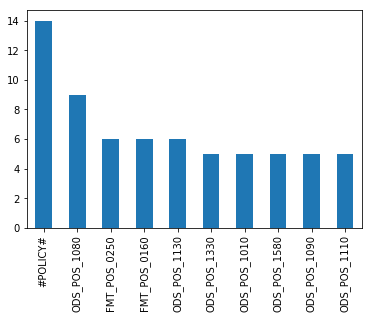

In [217]:
plt.figure();
docDF[:10].plot(kind='bar')

In [218]:
docDF[:5]

#POLICY#        14
ODS_POS_1080     9
FMT_POS_0250     6
FMT_POS_0160     6
ODS_POS_1130     6
Name: doc, dtype: int64

## 2. Target Set

In [219]:
def get_TargetDF(targetDoc, targetDocFolder):
    csvTargetFileName = '_Target.csv'
    csvTargetFile = get_CSV_FileName(targetDoc + csvTargetFileName, targetDocFolder)
    targetDF = pd.read_csv(csvTargetFile, index_col=False )
    target = get_TrainingDF(targetDF, targetDoc)
    return target

In [220]:
targetDoc = 'FMT_POS_190'
target = get_TargetDF(targetDoc, TrainingDataFolder)

FileNotFoundError: File b'/Users/MH/SourceTreeproject/PredictSheetAction/Python_Prediction/eachUser/TrainingDataSets/user4//FMT_POS_190_Target.csv' does not exist

## 3. Check DataSets

In [221]:
def get_TrainingDataShape(trainDataFrame, targetingDataFrame):
    print('Fearture Data Size (X): ', trainDataFrame.shape, ', Target Data Size (Y): ', targetingDataFrame.shape)

In [222]:
get_TrainingDataShape(data, target)

Fearture Data Size (X):  (222, 10) , Target Data Size (Y):  (1962,)


In [223]:
data.head(5)

,query_date_year,query_date_month,query_date_day,query_date_weekday,query_date_month_cos,query_date_month_sin,query_date_day_cos,query_date_day_sin,query_date_weekday_cos,query_date_weekday_sin
0,2017,0.166667,0.483871,0.428571,0.986143,0.165896,0.885201,0.465209,0.909560,0.415572
1,2017,0.166667,0.483871,0.428571,0.986143,0.165896,0.885201,0.465209,0.909560,0.415572
2,2017,0.166667,0.483871,0.428571,0.986143,0.165896,0.885201,0.465209,0.909560,0.415572
3,2017,0.166667,0.548387,0.714286,0.986143,0.165896,0.853366,0.521312,0.755561,0.655078
4,2017,0.166667,0.548387,0.714286,0.986143,0.165896,0.853366,0.521312,0.755561,0.655078


In [224]:
featureHead = data.axes[1]
print(featureHead)

Index(['query_date_year', 'query_date_month', 'query_date_day',
       'query_date_weekday', 'query_date_month_cos', 'query_date_month_sin',
       'query_date_day_cos', 'query_date_day_sin', 'query_date_weekday_cos',
       'query_date_weekday_sin'],
      dtype='object')


## 4. Classify model

In [225]:
def set_Training_RandomForest(trainDataFrame, targetingDataFrame):
    X_train, X_test, y_train, y_test = train_test_split(trainDataFrame, targetingDataFrame, test_size=0.30, random_state=30)
#     print('Training Data Size: ')
#     get_TrainingDataShape(X_train, y_train)
#     print('Test Data Size: ')
#     get_TrainingDataShape(X_test, y_test)
    model = RandomForestClassifier(n_estimators=30)
    model.fit(X_train, y_train)
    print('Test Model Score: ',model.score(X_test, y_test) )
    print("Click Rate: ",target.sum()/len(target)*100, "%")
    return model

def get_Date_YearMonthDay(target_year, target_month):
    month = Calendar().itermonthdates(target_year,target_month)
    allday =[day for day in month if day.month == target_month]
    return allday

def get_PredictInput(predicDate):
#     input normalized predict input
    year  = predicDate.year
    month = predicDate.month/12
    day = predicDate.day/31
    weekday = (predicDate.weekday()+1)/7
    PredictInput = [year, month, day, weekday, math.cos(month),math.sin(month),math.cos(day), \
                    math.sin(day),math.cos(weekday),math.sin(weekday)]
    return PredictInput

In [226]:
model  = set_Training_RandomForest(data, target)

ValueError: Found input variables with inconsistent numbers of samples: [222, 1962]

In [227]:
data.head(5)

,query_date_year,query_date_month,query_date_day,query_date_weekday,query_date_month_cos,query_date_month_sin,query_date_day_cos,query_date_day_sin,query_date_weekday_cos,query_date_weekday_sin
0,2017,0.166667,0.483871,0.428571,0.986143,0.165896,0.885201,0.465209,0.909560,0.415572
1,2017,0.166667,0.483871,0.428571,0.986143,0.165896,0.885201,0.465209,0.909560,0.415572
2,2017,0.166667,0.483871,0.428571,0.986143,0.165896,0.885201,0.465209,0.909560,0.415572
3,2017,0.166667,0.548387,0.714286,0.986143,0.165896,0.853366,0.521312,0.755561,0.655078
4,2017,0.166667,0.548387,0.714286,0.986143,0.165896,0.853366,0.521312,0.755561,0.655078


In [228]:
allday = get_Date_YearMonthDay(2017,5)
PredictInput = get_PredictInput(allday[0])
print("PredictInput: ",PredictInput)

PredictInput:  [2017, 0.4166666666666667, 0.03225806451612903, 0.14285714285714285, 0.9144430665938302, 0.40471456356112473, 0.9994797537524555, 0.032252470276413724, 0.9898132604466151, 0.14237172979226365]


In [229]:
def get_PredictResult(targetDoc, ClickDoc_Prob = .05):
    print("Predic Doc Name: " + targetDoc )
    predict_history = []
    for predic_month in range(12):
        allday = get_Date_YearMonthDay(2017,predic_month+1)
        for day in allday:
            PredictInput = get_PredictInput(day)
            doc_predict = model.predict([PredictInput])
            doc_predict_proba = model.predict_proba([PredictInput])
            if (len(doc_predict_proba[0]) > 1):
                if (doc_predict_proba[0][1] >= ClickDoc_Prob):
                    predict_history.append([targetDoc,day.strftime('%m/%d/%Y'),day.weekday()+1,doc_predict_proba[0][1]])
#                     print(day," weekday: ", day.weekday()+1)
#                     print("user feature: ", ('doc_' + targetDoc), " click prob: ", doc_predict_proba) 
    return predict_history

In [230]:
getpredic = get_PredictResult(targetDoc)
getpredic[:5]

Predic Doc Name: FMT_POS_190


[]

In [206]:
doc_predict_proba = model.predict_proba([PredictInput])
len(doc_predict_proba[0])
docDFHead[:5]

Index(['FMT_PA_0780', 'FMT_PA_0852', 'FMT_POS_0360', 'FMT_POS_0290',
       'FMT_POS_0180'],
      dtype='object')

In [237]:
# 1
# UserName = 'mPOS'
# UserName = 'CSIS-SIT3'
UserName = 'user1'
# UserName = 'user4'

TrainingDataFolder = 'TrainingDataSets/' + UserName + '/'
csvTrainingFile = get_CSV_FileName('TrainingFeature.csv', TrainingDataFolder)

trainDF = pd.read_csv(csvTrainingFile, index_col=False )
feature = [  'query_date_year' , 'query_date_month'  ,'query_date_day', 'query_date_weekday'  ]
data = pd.get_dummies(get_TrainingDF(trainDF,feature))
data = get_PeriodTrainingDF(data)
data = get_NormalizedTrainingDF(data)

docDFHead = pd.read_csv(csvTrainingFile, index_col=False)['doc'].value_counts(0).axes[0]
clickDocPrediction = []

for idx, targetDoc in enumerate(docDFHead):
    if(idx%10==0):
        print("Processing: {0:.2f}%".format(idx*100/len(docDFHead)))

    target = get_TargetDF(targetDoc, TrainingDataFolder)
    model  = set_Training_RandomForest(data, target)
    predictEachDoc = get_PredictResult(targetDoc)
    if (len(predictEachDoc)> 0):
        clickDocPrediction.extend(predictEachDoc)
    elif (len(predictEachDoc) == 0):
        print(targetDoc, "No click in prediction")

Processing: 0.00%
Test Model Score:  0.934579439252
Click Rate:  6.47887323944 %
Predic Doc Name: #POLICY#
Test Model Score:  0.96261682243
Click Rate:  5.35211267606 %
Predic Doc Name: ODS_FIN_0860
Test Model Score:  0.934579439252
Click Rate:  3.94366197183 %
Predic Doc Name: ODS_FIN_0770
Test Model Score:  0.981308411215
Click Rate:  2.81690140845 %
Predic Doc Name: ODS_FIN_0730
Test Model Score:  0.943925233645
Click Rate:  2.81690140845 %
Predic Doc Name: FMT_POS_0250
Test Model Score:  0.981308411215
Click Rate:  2.25352112676 %
Predic Doc Name: ODS_FIN_0830
Test Model Score:  0.96261682243
Click Rate:  2.25352112676 %
Predic Doc Name: ODS_FIN_1340
Test Model Score:  0.990654205607
Click Rate:  1.97183098592 %
Predic Doc Name: FMT_PA_0850
Test Model Score:  0.971962616822
Click Rate:  1.69014084507 %
Predic Doc Name: FMT_POS_0380
Test Model Score:  0.981308411215
Click Rate:  1.69014084507 %
Predic Doc Name: ODS_FIN_0810
Processing: 7.41%
Test Model Score:  1.0
Click Rate:  1.408

In [238]:
predicDF = pd.DataFrame(clickDocPrediction, columns=['doc', 'query_date', 'query_date_weekday', 'click rate'])
predicDF = predicDF.sort_values(by=['query_date'])

TrainingDataFolder = 'PredictionResult'
csvPreditionFile = get_CSV_FileName(UserName + '_PredictDoc_10_Feature.csv', TrainingDataFolder)
check_file_path_exist(csvPreditionFile)

predicDF.to_csv(csvPreditionFile)

In [239]:
predicDF.head(5)

,doc,query_date,query_date_weekday,click rate
0,#POLICY#,01/01/2017,7,0.142504
2197,ODS_POS_1340,01/01/2017,7,0.229524
2046,ODS_POS_7030,01/01/2017,7,0.074395
2012,ODS_POS_1250,01/01/2017,7,0.129505
467,ODS_FIN_0730,01/01/2017,7,0.059444
